# CPA sur AES — TP4 *Carte à puce & sécurité des implémentations*

L’objectif de ce TP est de comprendre et reproduire une **attaque CPA (Correlation Power Analysis)** sur un chiffrement **AES**.  
Le principe consiste à exploiter des **traces de consommation électrique** (ou électromagnétiques) pour retrouver une **clé secrète** utilisée pendant le chiffrement.  

Je reprends ici la structure du notebook original fourni par l’enseignant, mais en reformulant et en ajoutant mes propres commentaires pour montrer ma compréhension de chaque étape.

**Plan du notebook :**
1. Chargement des librairies et configuration initiale  
2. Importation et préparation des traces de consommation  
3. Définition du modèle de fuite (poids de Hamming)  
4. Corrélation entre hypothèses et traces (CPA)  
5. Sélection de la clé la plus probable et visualisation des résultats  
6. Bilan rapide et remarques personnelles




<img src='images/CPA formula.png' style='width: 600px'>


In [15]:
# Import des librairies scientifiques nécessaires
import numpy as np             
import matplotlib.pyplot as plt 
from tqdm import tqdm           
import time                     
import os     
import estraces

# Configuration graphique
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True



## Import the traces needed for the analysis

In [16]:
# Lecture du fichier ETS (adapter le chemin si nécessaire)
ETS_PATH = "SideSCA-Traces-Public/AES_xmega_traces_set_NewAE.ets"
ths = estraces.read_ths_from_ets_file(ETS_PATH)
# Affichage simple pour confirmer la lecture
print("Objet THS chargé :", type(ths))

print(ths)


Objet THS chargé : <class 'estraces.traces._metaclass.TraceHeaderSetForETSFormatReader'>
Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file SideSCA-Traces-Public/AES_xmega_traces_set_NewAE.ets with 50 traces.
key..............: uint8
plaintext........: uint8



In [17]:
import numpy as np

raw_traces = ths.traces  

# Si chaque élément a .samples ou .get_points, on l'utilise
def get_points(t):
    if hasattr(t, "samples"):
        return np.asarray(t.samples)
    if hasattr(t, "get_points"):
        return np.asarray(t.get_points())
    # sinon tenter une conversion directe
    return np.asarray(t)

# Construire la matrice (n_traces, n_samples)
samples_list = [get_points(t) for t in raw_traces]
# Si longueurs identiques -> empiler, sinon afficher distribution
lengths = [s.shape[0] for s in samples_list]
if len(set(lengths)) == 1:
    traces_mat = np.vstack(samples_list)
else:
    print("ATTENTION : traces de longueurs différentes :", np.unique(lengths, return_counts=True))
    # on empile en coupant/complétant à la longueur minimale pour avancer rapidement
    minlen = min(lengths)
    traces_mat = np.vstack([s[:minlen] for s in samples_list])
    print(f"Traces tronquées à la longueur minimale {minlen} pour former traces_mat.")

# --- Extraction des plaintexts ---
texts_in = None
if hasattr(ths, "plaintext"):
    texts_in = np.asarray(ths.plaintext)
elif hasattr(ths, "get") and ths.get("plaintext") is not None:
    texts_in = np.asarray(ths.get("plaintext"))

# --- Affichages de vérification ---
print("traces_mat shape :", traces_mat.shape, " dtype:", traces_mat.dtype)
print("texts_in type/shape :", None if texts_in is None else (type(texts_in), texts_in.shape))

# Aperçu lisible (3 premiers plaintexts)
if texts_in is not None:
    for i in range(min(3, texts_in.shape[0])):
        el = texts_in[i]
        if isinstance(el, (bytes, bytearray)):
            print(f"[{i}]:", el.hex())
        else:
            try:
                arr = np.asarray(el, dtype=np.uint8)
                print(f"[{i}]:", arr)
            except Exception:
                print(f"[{i}]:", el)
else:
    print("Aucun plaintext extrait automatiquement (ths.plaintext absent).")


traces_mat shape : (50, 3000)  dtype: float64
texts_in type/shape : (<class 'numpy.ndarray'>, (50, 16))
[0]: [  3   2  47 199 170 136 125  23  37 139  60 129   3 230 185   0]
[1]: [107  60 139 130 197 232  54 219  31 248  97   0 196  27   2 133]
[2]: [ 48 161 114 213  59  29  18 173 210  14  88 203 243 239  32 165]


## Tracer et observer les traces

But : visualiser les traces pour repérer la fenêtre d'intérêt, vérifier l'alignement et estimer le bruit.


Nombre de traces: 50 — longueur d'une trace: 3000


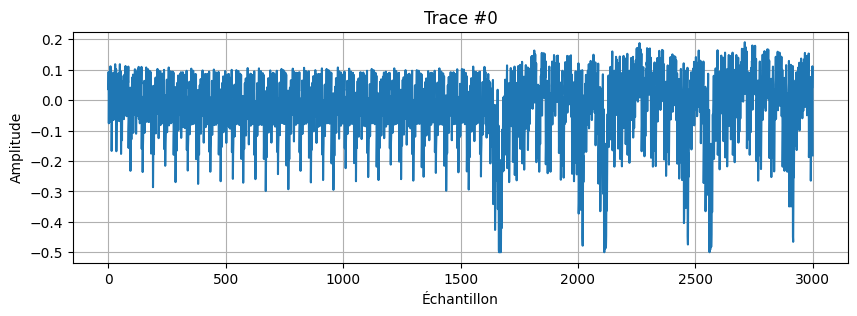

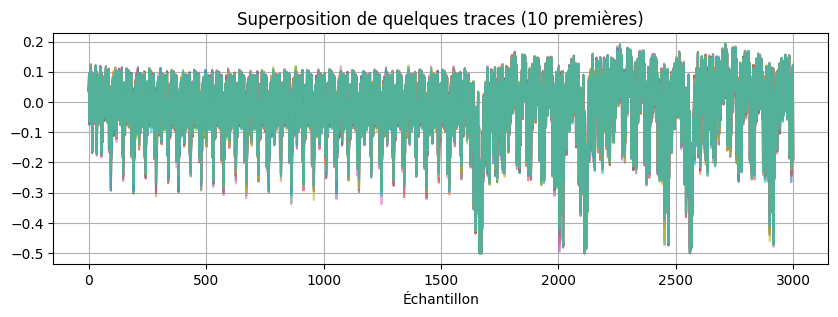

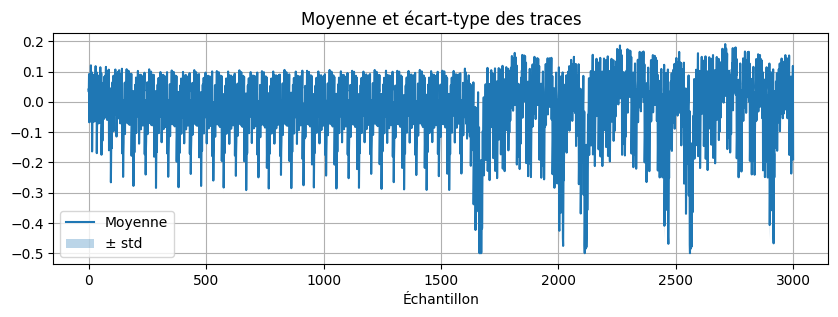

In [18]:

n_traces, n_samples = traces_mat.shape
print("Nombre de traces:", n_traces, "— longueur d'une trace:", n_samples)

# 1) Une trace individuelle
plt.figure(figsize=(10,3))
plt.plot(traces_mat[0])
plt.title("Trace #0")
plt.xlabel("Échantillon")
plt.ylabel("Amplitude")
plt.show()

# 2) Superposition d'une dizaine de traces pour vérifier l'alignement
plt.figure(figsize=(10,3))
for i in range(min(10, n_traces)):
    plt.plot(traces_mat[i], alpha=0.6)
plt.title("Superposition de quelques traces (10 premières)")
plt.xlabel("Échantillon")
plt.show()

# 3) Moyenne plus ou moins écart-type (aperçu des zones significatives)
mean_trace = np.mean(traces_mat, axis=0)
std_trace = np.std(traces_mat, axis=0)

plt.figure(figsize=(10,3))
plt.plot(mean_trace, label="Moyenne")
plt.fill_between(np.arange(n_samples), mean_trace - std_trace, mean_trace + std_trace, alpha=0.3, label="± std")
plt.title("Moyenne et écart-type des traces")
plt.xlabel("Échantillon")
plt.legend()
plt.show()


In [21]:
import estraces
import scared


# 'ths' est déjà chargé via estraces.read_ths_from_ets_file(...)
container = scared.Container(ths)

attack_dpa = scared.DPAAttack(
    selection_function = scared.aes.selection_functions.encrypt.FirstSubBytes(),
    model = scared.Monobit(0),
    discriminant = scared.maxabs,
    convergence_step = len(ths) // 5
)

# lancer de l'attaques 
attack_dpa.run(container)

# scores: shape (256, 16)
found_key = attack_dpa.scores.argmax(0).squeeze()

# afficher en hex comme dans le notebook
vhex = np.vectorize(hex)
print("the key found is: ", vhex(found_key))
print("the correct key is: ", vhex(ths[0].key))



the key found is:  ['0x92' '0xd7' '0x33' '0x21' '0x55' '0x3' '0x24' '0x74' '0x7' '0xfb'
 '0x44' '0x36' '0xb' '0xb7' '0x29' '0x54']
the correct key is:  ['0x2b' '0x7e' '0x15' '0x16' '0x28' '0xae' '0xd2' '0xa6' '0xab' '0xf7'
 '0x15' '0x88' '0x9' '0xcf' '0x4f' '0x3c']


results.shape : (256, 16, 3000)
scores.shape  : (256, 16)
convergence_traces.shape : (256, 16, 5)


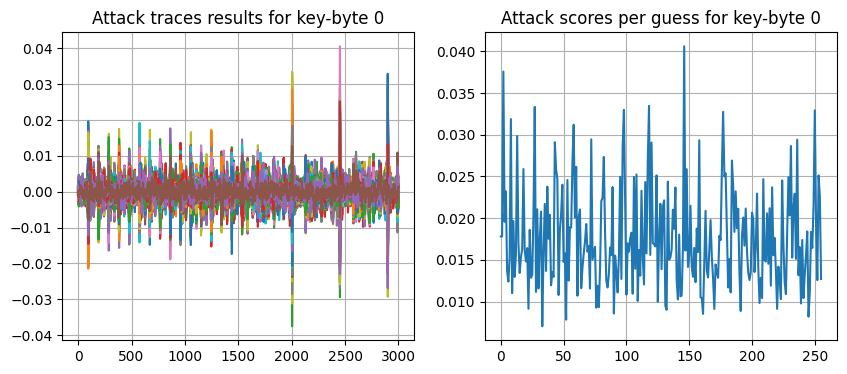

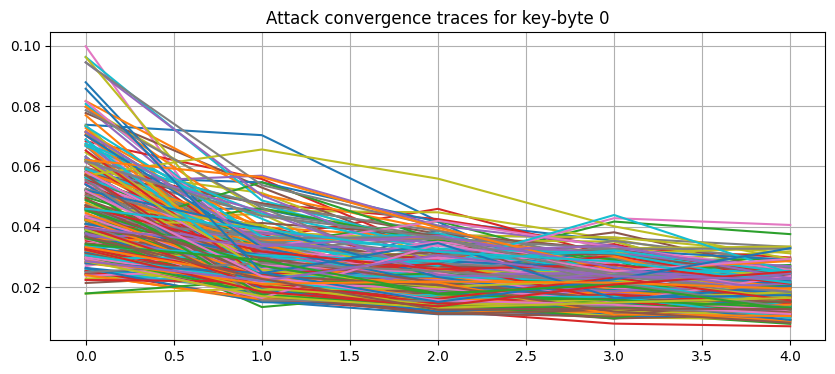

In [22]:
# formes utiles
print("results.shape :", attack_dpa.results.shape)            # attendu (256,16, <n_points>)
print("scores.shape  :", attack_dpa.scores.shape)             # attendu (256,16)
print("convergence_traces.shape :", attack_dpa.convergence_traces.shape)  # attendu (256,16,5) selon convergence_step

# Tracé pour un octet donné (ici key_byte = 0)
key_byte = 0
plt.subplot(1,2,1)
plt.title('Attack traces results for key-byte '+str(key_byte))
plt.plot(attack_dpa.results.T[:, key_byte, :])
plt.subplot(1,2,2)
plt.title('Attack scores per guess for key-byte '+str(key_byte))
plt.plot(attack_dpa.scores[:, key_byte])
plt.show()

plt.title('Attack convergence traces for key-byte '+str(key_byte))
plt.plot(attack_dpa.convergence_traces.T[:, key_byte, :])
plt.show()


## CPA — Corrélation 


In [27]:
import numpy as np

stds = traces_mat.std(axis=0)
zeros = (stds == 0)
print("Colonnes à std==0 :", zeros.sum())

if zeros.any():
    eps = 1e-12
    # ajouter un bruit gaussien très petit uniquement sur ces colonnes
    traces_mat[:, zeros] += np.random.normal(scale=eps, size=(traces_mat.shape[0], zeros.sum()))
    # Reconstruire le container à partir de traces_mat/texts_in 
    try:
        container = scared.Container(traces_mat, texts_in)
    except Exception:
        # fallback : remettre container = scared.Container(ths) si l'API diffère
        container = scared.Container(ths)
    print("Bruit ajouté.")
else:
    print("Aucune colonne à variance nulle détectée.")


Colonnes à std==0 : 0
Aucune colonne à variance nulle détectée.


In [30]:
# Instanciation de l'attaque CPA
attack_cpa = scared.CPAAttack(
    selection_function = scared.aes.selection_functions.encrypt.FirstSubBytes(),  # cible FirstSubBytes
    model = scared.HammingWeight(),         # modèle : poids de Hamming
    discriminant = scared.maxabs,           # critère de sélection : max absolute value
    convergence_step = len(ths) // 5        # pas pour traces de convergence
)

attack_cpa.run(container)

# Récupérer l'octet candidat par maximisation des scores (256 x 16 -> argmax sur 0)
found_key = attack_cpa.scores.argmax(0).squeeze()

# Affichage lisible en hex
vhex = np.vectorize(hex)
print("the key found is: ", vhex(found_key))
print("the correct key is: ", vhex(ths[0].key)) 

print("results.shape :", attack_cpa.results.shape)         
print("scores.shape  :", attack_cpa.scores.shape)        
print("convergence.shape :", attack_cpa.convergence_traces.shape)



the key found is:  ['0x2b' '0x7e' '0x15' '0x16' '0x28' '0xae' '0xd2' '0xa6' '0xab' '0xf7'
 '0x15' '0x88' '0x9' '0xcf' '0x4f' '0x3c']
the correct key is:  ['0x2b' '0x7e' '0x15' '0x16' '0x28' '0xae' '0xd2' '0xa6' '0xab' '0xf7'
 '0x15' '0x88' '0x9' '0xcf' '0x4f' '0x3c']
results.shape : (256, 16, 3000)
scores.shape  : (256, 16)
convergence.shape : (256, 16, 5)


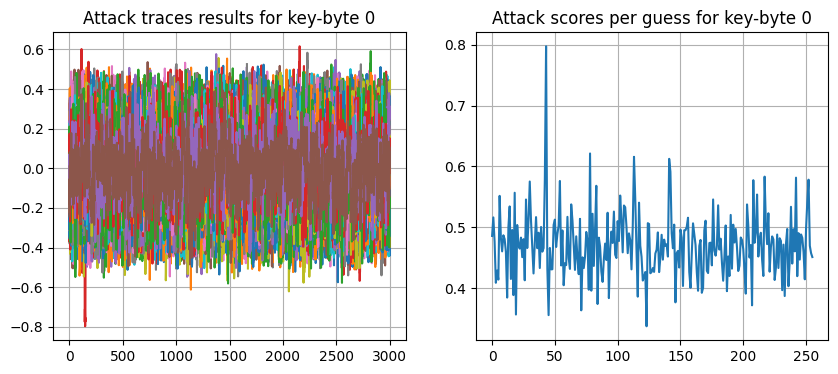

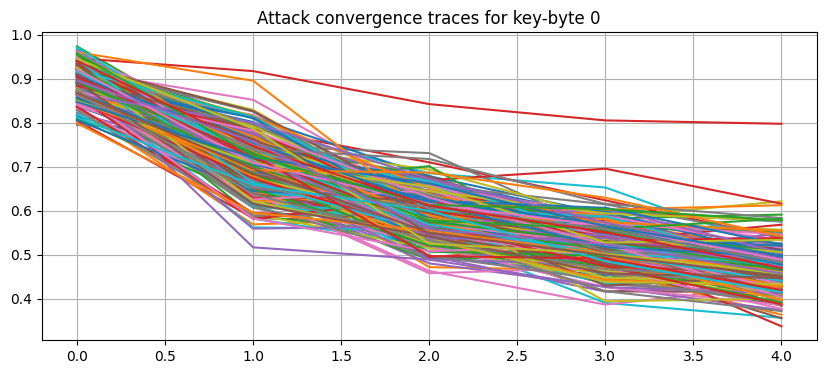

In [32]:
key_byte = 0

# 1) Traces de résultat (pour chaque guess) pour l'octet
plt.subplot(1,2,1)
plt.title('Attack traces results for key-byte '+str(key_byte))
plt.plot(attack_cpa.results.T[:, key_byte, :])   # shape -> (n_points, 256) transposé
# 2) Scores par candidat pour l'octet
plt.subplot(1,2,2)
plt.title('Attack scores per guess for key-byte '+str(key_byte))
plt.plot(attack_cpa.scores[:, key_byte])
plt.show()

# 3) Traces de convergence (comment : montres l'évolution selon le nombre de traces)
plt.title('Attack convergence traces for key-byte '+str(key_byte))
plt.plot(attack_cpa.convergence_traces.T[:, key_byte, :])
plt.show()
